# Final Project
Using plot synopses of movies to predict the genre of the film.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Data Collection and Cleaning

### Import Datasets

In [3]:
## read in data
basics = pd.read_csv('title.basics.tsv', sep='\t')
ratings = pd.read_csv('title.ratings.tsv', sep='\t')
synopses = pd.read_csv('mpst_full_data.csv')

In [93]:
#basics.head()

In [94]:
#ratings.head()

In [95]:
#synopses.head()

In [96]:
## merge all
all = pd.merge(left=pd.merge(basics, ratings, 'inner', on='tconst'), 
               right=synopses, how='inner', left_on='tconst', right_on='imdb_id')
all.head(3)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0000091,short,The House of the Devil,Le manoir du diable,0,1896,\N,3,"Horror,Short",6.7,2859,tt0000091,Le manoir du diable,The film opens with a large bat flying into a ...,"paranormal, gothic",train,wikipedia
1,tt0000225,short,Beauty and the Beast,La belle et la bête,0,1899,\N,\N,"Family,Fantasy,Romance",5.1,18,tt0000225,La belle et la bête,A widower merchant lives in a mansion with his...,fantasy,train,wikipedia
2,tt0000230,short,Cinderella,Cendrillon,0,1899,\N,6,"Drama,Family,Fantasy",6.5,1358,tt0000230,Cendrillon,"A prologue in front of the curtain, suppressed...",fantasy,train,wikipedia


In [97]:
print('Number of movies with plot data:', synopses.shape[0])
print('Number of movies after merge:', all.shape[0])

Number of movies with plot data: 14828
Number of movies after merge: 14765


The IMDb basics dataset is quite large, containing a lot of information about all IMDb tracked digital media content. Including **`genre`**, which is the response variable that I'm hope to be able to predict using a multinomial classification approach. Some other variables in this dataset could also be useful (like `runtime` and `release year`). Each movie has an ID under the `tconst` variable.

The second IMDb dataset includes rating information and the unique identifier under the `tconst` variable. The only other features in this dataset are `averageRating` and `numVotes`. These are the average of all user ratings and the number of user votes the film received.

The MPST Kaggle dataset is much smaller, containing plot descriptions and summaries that were collected from IMDb and Wikipedia pages. There is also an `imdb_id`, which corresponds directly to the `tconst` variable that uniquely identifies each film in the IMDb datasets. This made it possible to merge the IMDb data with the Kaggle plot synopsis data. The resulting dataframe has a total of 14,765 observations, for which the movie had both plot and IMDb information.

At this point, what's left over are movies for which there is an available plot summary. Additional filtering and cleaning will be performed in the next section.

### Data Cleaning

In [110]:
## filter down to only non-adult movie content that came out after 1950
movies = all[(all['titleType'] == 'movie') & 
             (all['isAdult'] == 0) & 
             (all['startYear'].astype(int) > 1950)]

## drop unnecessary variables
movies.drop(['titleType', 'originalTitle', 'isAdult', 'endYear', 'imdb_id', 
             'title', 'tags', 'split', 'synopsis_source'],
            axis = 1, inplace = True)
movies.head()

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,plot_synopsis
756,tt0035423,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",6.4,78334,"On 28 April 1876, Leopold, His Grace the 3rd D..."
1336,tt0042478,The Franchise Affair,1951,88,"Crime,Drama,Mystery",7.1,206,"Robert Blair, a local solicitor, is called on ..."
1342,tt0042539,Halls of Montezuma,1951,113,"Action,Adventure,Drama",6.6,2458,"During World War II, a Marine battalion prepar..."
1349,tt0042619,Diary of a Country Priest,1951,115,Drama,7.9,9949,An idealistic young priest arrives at Ambricou...
1382,tt0043086,Under the Gun,1951,83,"Crime,Drama,Film-Noir",6.8,117,"At a Miami nightclub, gangster Bert Galvin off..."


#### Missing values

Missing values are represented in the data by a '\N' character. Some of these can be imputed, like `runtimeMinutes` which will be replaced with the variable mean. Others like `startYear` and `genre` should be removed (especially the oberservations that do not have data in the genre field, as that is the target variable).

In [112]:
## replace \N strings with NaNs
movies.replace(to_replace = '\\N', value = np.nan, inplace = True)

## make runtimeMinutes numeric, fill NAs with the mean
movies['runtimeMinutes'] = pd.to_numeric(movies['runtimeMinutes'])
movies['runtimeMinutes'].fillna(movies['runtimeMinutes'].mean(), inplace = True)

## drop remaining NAs and any duplicate movies/plots
movies_clean = movies.dropna().drop_duplicates(['primaryTitle', 'plot_synopsis'])

## reformat
movies_clean.reset_index(drop = True, inplace = True)
movies_clean.head()

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,plot_synopsis
0,tt0035423,Kate & Leopold,2001,118.0,"Comedy,Fantasy,Romance",6.4,78334,"On 28 April 1876, Leopold, His Grace the 3rd D..."
1,tt0042478,The Franchise Affair,1951,88.0,"Crime,Drama,Mystery",7.1,206,"Robert Blair, a local solicitor, is called on ..."
2,tt0042539,Halls of Montezuma,1951,113.0,"Action,Adventure,Drama",6.6,2458,"During World War II, a Marine battalion prepar..."
3,tt0042619,Diary of a Country Priest,1951,115.0,Drama,7.9,9949,An idealistic young priest arrives at Ambricou...
4,tt0043086,Under the Gun,1951,83.0,"Crime,Drama,Film-Noir",6.8,117,"At a Miami nightclub, gangster Bert Galvin off..."


#### Refine `genre` feature

In [115]:
## extract the main genre (assume it is the first listed)
movies_clean['genre'] = movies_clean['genres'].apply(lambda x: re.findall('\w+', x)[0])
movies_clean.drop(['genres'], axis = 1, inplace = True)
movies_clean.head()

print('Number of unique primary genres:', movies_clean['genre'].nunique())
print('Number of movies of each genre:')
print(movies_clean['genre'].value_counts())

Number of unique primary genres: 20
Number of movies of each genre:
Action         2592
Comedy         2390
Drama          2075
Horror          998
Crime           978
Adventure       778
Biography       434
Animation       118
Western          95
Fantasy          89
Mystery          65
Documentary      62
Sci              37
Thriller         34
Romance          31
Family           23
Musical          15
Music             3
History           1
Film              1
Name: genre, dtype: int64


# Second Try - keep less genres and don't have Other group

Three main classes:

   1. Action
   2. Comedy
   3. Horror

In [122]:
## keep only movies of the three genres of interest
movies_keep = movies_clean[(movies_clean['genre'] == 'Action') |
                           (movies_clean['genre'] == 'Comedy') |
                           (movies_clean['genre'] == 'Horror')]
movies_keep.head()

,tconst,primaryTitle,startYear,runtimeMinutes,averageRating,numVotes,plot_synopsis,genre
0,tt0035423,Kate & Leopold,2001,118.0,6.4,78334,"On 28 April 1876, Leopold, His Grace the 3rd D...",Comedy
2,tt0042539,Halls of Montezuma,1951,113.0,6.6,2458,"During World War II, a Marine battalion prepar...",Action
9,tt0043288,Anne of the Indies,1951,81.0,6.7,1173,"After seizing a British ship, the barefoot, fe...",Action
16,tt0043371,Callaway Went Thataway,1951,81.0,6.5,593,Mike Frye (MacMurray) and Deborah Patterson (M...,Comedy
17,tt0043379,Captain Horatio Hornblower R.N.,1951,117.0,7.3,6052,"In 1807, during the Napoleonic Wars, British R...",Action


# Original Process - leads to too many classes to deal with

Make **Action, Comedy, Drama, Crime, Horror, and Adventure** the five main classes. All others can be lumped together in an **Other** category.

In [125]:
## lump smaller genre groups into a bigger OTHER level
# other = ['Biography', 'Western', 
#          'Animation', 'Fantasy',
#          'Mystery', 'Documentary',
#          'Romance', 'Thriller',
#          'Sci', 'Family',
#          'Musical', 'Film',
#          'Music', 'History']

# movies_clean['genre'] = movies_clean['genre'].replace(to_replace = other, value = "Other")
# movies_clean.drop(['genres'], axis = 1, inplace = True)
# movies_clean.head()

#### Text Cleaning

In [178]:
## stopwords
sw = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 
      'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 
      'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
      'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
      'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
      'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
      'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
      'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
      'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
      'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't",
      'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn',
      "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't",'isn', 
      "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', 
      "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", "from", "subject"]

## list of 200 plot words that are most common between all three genres
hifreq_pw = list(common_pw)

## function to clean
def clean_text(x):
    x = x.lower()
    tokens = word_tokenize(x)
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [tok for tok in tokens if tok not in sw]
    #tokens = [tok for tok in tokens if tok not in common_plot_w]
    return " ".join(tokens)

In [124]:
## clean all synopses
cleaned_movies = movies_keep['plot_synopsis'].apply(lambda x: clean_text(x))

### Top Words by Genre

In [126]:
## clean synopses for movies in all the individual genres, use this to determine the top words in each genre
cleaned_action = movies_keep[movies_keep['genre'] == 'Action']['plot_synopsis'].apply(lambda x: clean_text(x))
cleaned_comedy = movies_keep[movies_keep['genre'] == 'Comedy']['plot_synopsis'].apply(lambda x: clean_text(x))
cleaned_horror = movies_keep[movies_keep['genre'] == 'Horror']['plot_synopsis'].apply(lambda x: clean_text(x))

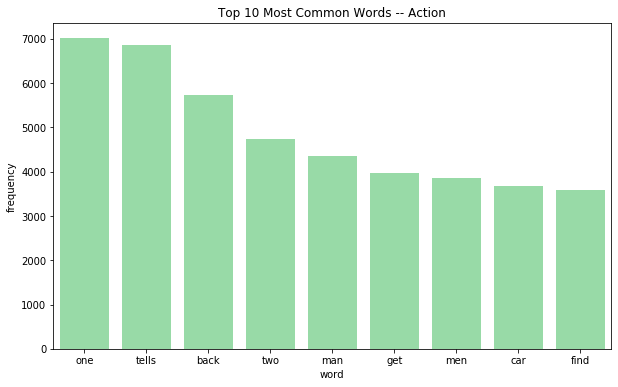

In [131]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(cleaned_action)
freq_df_action = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_action = freq_df_action.sum(axis=0).sort_values(ascending=False).reset_index()

f, ax = plt.subplots(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(x=top_action.iloc[0:9,0], y=top_action.iloc[0:9,1],
            label="Total", color="g")
ax.set(ylabel="frequency",
       xlabel="word",
       title="Top 10 Most Common Words -- Action")
f.show()

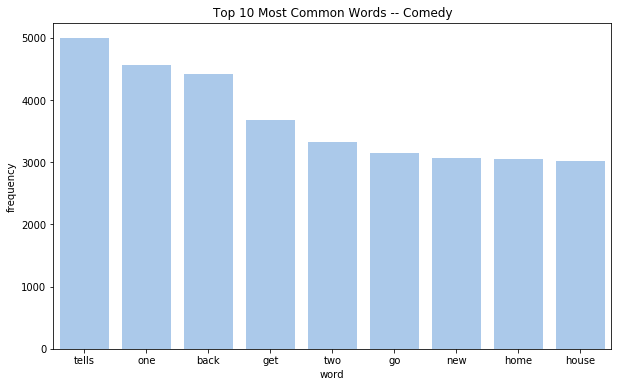

In [133]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(comedy_cleaned)
freq_df_comedy = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_comedy = freq_df_comedy.sum(axis=0).sort_values(ascending=False).reset_index()

f, ax = plt.subplots(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(x=top_comedy.iloc[0:9,0], y=top_comedy.iloc[0:9,1],
            label="Total", color="b")
ax.set(ylabel="frequency",
       xlabel="word",
       title="Top 10 Most Common Words -- Comedy")
f.show()

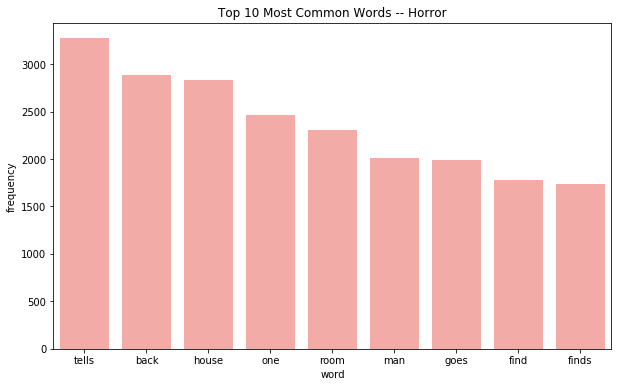

In [134]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(cleaned_horror)
freq_df_horror = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_horror = freq_df_horror.sum(axis=0).sort_values(ascending=False).reset_index()

f, ax = plt.subplots(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(x=top_horror.iloc[0:9,0], y=top_horror.iloc[0:9,1],
            label="Total", color="r")
ax.set(ylabel="frequency",
       xlabel="word",
       title="Top 10 Most Common Words -- Horror")
f.show()

At this point, I noticed that there are a lot of similarities in the top words for these three genres. I decided to create an additional list of words, plot stop-words in a sense, to remove in the text-cleaning process. These are words that are common to all written movie synopses.

In [166]:
## find common words between all genres
common_pw = pd.merge(left=pd.merge(left=top_action, right=top_comedy, how='inner', on='index',
                                   suffixes=('_action', '_comedy')),
                     right=top_horror, how='inner', on='index')
common_pw['total'] = common_pw.iloc[:,1] + common_pw.iloc[:,2] + common_pw.iloc[:,3]

## take top 200
most_common_pw = common_pw.sort_values(ascending=False, by='total').iloc[0:200,0]

In [181]:
## list of 200 plot words that are most common between all three genres
hifreq_pw = list(most_common_pw)

## function to clean
def new_clean_text(x):
    x = x.lower()
    tokens = word_tokenize(x)
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [tok for tok in tokens if tok not in sw]
    tokens = [tok for tok in tokens if tok not in hifreq_pw]
    return " ".join(tokens)

In [182]:
new_cleaned_action = movies_keep[movies_keep['genre'] == 'Action']['plot_synopsis'].apply(lambda x: new_clean_text(x))
new_cleaned_comedy = movies_keep[movies_keep['genre'] == 'Comedy']['plot_synopsis'].apply(lambda x: new_clean_text(x))
new_cleaned_horror = movies_keep[movies_keep['genre'] == 'Horror']['plot_synopsis'].apply(lambda x: new_clean_text(x))

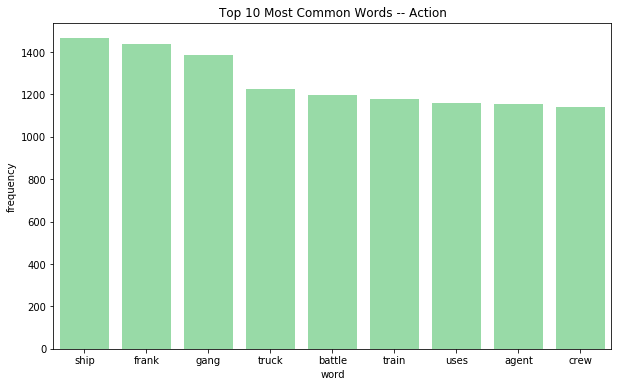

In [183]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(new_cleaned_action)
freq_df_action = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_action = freq_df_action.sum(axis=0).sort_values(ascending=False).reset_index()

f, ax = plt.subplots(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(x=top_action.iloc[0:9,0], y=top_action.iloc[0:9,1],
            label="Total", color="g")
ax.set(ylabel="frequency",
       xlabel="word",
       title="Top 10 Most Common Words -- Action")
f.show()

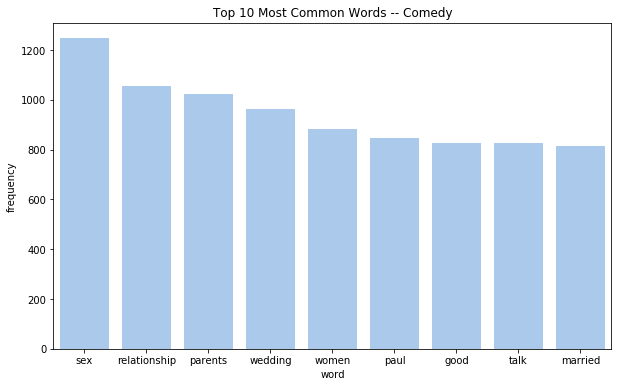

In [185]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(new_cleaned_comedy)
freq_df_comedy = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_comedy = freq_df_comedy.sum(axis=0).sort_values(ascending=False).reset_index()

f, ax = plt.subplots(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(x=top_comedy.iloc[0:9,0], y=top_comedy.iloc[0:9,1],
            label="Total", color="b")
ax.set(ylabel="frequency",
       xlabel="word",
       title="Top 10 Most Common Words -- Comedy")
f.show()

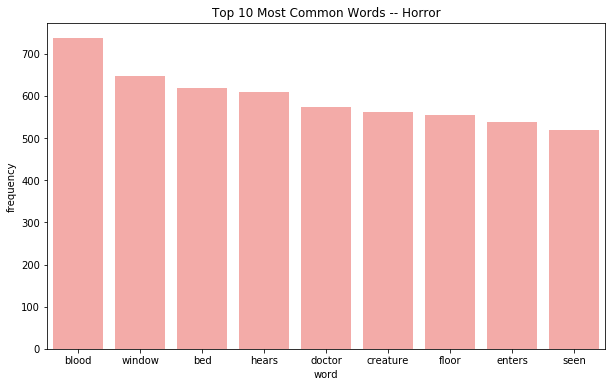

In [186]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(new_cleaned_horror)
freq_df_horror = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_horror = freq_df_horror.sum(axis=0).sort_values(ascending=False).reset_index()

f, ax = plt.subplots(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(x=top_horror.iloc[0:9,0], y=top_horror.iloc[0:9,1],
            label="Total", color="r")
ax.set(ylabel="frequency",
       xlabel="word",
       title="Top 10 Most Common Words -- Horror")
f.show()

These top 10 most common words look a lot better now!!

### TF-IDF